# **Cazando al wumpus**

Carlos Garavito, Emmanuel Moreno
***


## Descripción del problema

## Estrategia para la caza del wumpus

Para realizar la casa del wumpus, se sacará provecho del trabajo realizado en clase, en donde se desarrolla la base de conocimiento del `mundo del wumpus`. En este, en la mayoria de casos el agente es capaz de explorar seguro el laberinto, encontrar el oro y escapar. Esto es, se desarrollo una base de conocimiento que
- identifica lugares seguros de acuerdo a la respuesta de los sensores
- una vez encuentra el oro, escoge la ruta mas corta hacia la salida con las casillas visitadas seguras. 

de esta manera, la base de conocimiento y los métodos de la clase agente que la crean, se incluyen en el paquete `agente_wkb`. 

## Cazando al wumpus

In [33]:
# define rutas de trabajo e importa ambiente de trabajo
import os
import sys

CURRENT_PATH = os.getcwd()
NOTEBOOKS_PATH = os.path.join(CURRENT_PATH, os.path.pardir, 'notebooks')
PYTHON_PATH = os.path.join(CURRENT_PATH, os.path.pardir, 'python')
sys.path.append(PYTHON_PATH)

from logica import *
from entornos import *
from wkb import *
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import Counter


from busqueda import best_first_search, solucion, breadth_first_search

### Base de conocimiento `alerta_wumpus`

In [34]:
# crea la base de conocimientos de alerta de wumpus

def alerta_wumpus(self):
    x, y = self.loc
    turno = self.turno
    formulas = []
    formulas += [
        f'en({x},{y})_{turno}Yhedor_{turno}>alerta_wumpus({x},{y})',  
    ]
    return formulas

setattr(Agente_wkb, 'alerta_wumpus', alerta_wumpus)


In [35]:
# modifica el metodo `estimar_estado_wkb` para incluir 
# `alerta_wumpus`

def estimar_estado_wkb2(self, W):
    self.base.TELL(f'segura({self.loc[0]},{self.loc[1]})')
    cas_seguras = self.adyacentes_seguras_wkb()
    self.base.TELL('Y'.join([f'segura({c[0]},{c[1]})' for c in cas_seguras]))
    nueva_dir = self.nueva_direccion_wkb()
    self.base.TELL(nueva_dir)
    nueva_pos = self.nueva_posicion_wkb()
    self.base.TELL(nueva_pos)
    formulas = [d for d in self.base.datos if f'_{self.turno}' in d]
    formulas += [s for s in self.base.datos if 'segura' in s]
    formulas += self.fluentes_mapa_mental_wkb()
    formulas += self.brisa_pozo_wkb()
    formulas += self.hedor_wumpus_wkb()
    formulas += self.casilla_segura_wkb()
    formulas += self.casillas_visitadas_wkb()
    formulas += self.alerta_wumpus() # new
    self.perceptos = W.para_sentidos()
    formulas += [self.interp_percepto_wkb(mundo='wumpus')]
    self.base = LPQuery(formulas)

setattr(Agente_wkb, 'estimar_estado_wkb', estimar_estado_wkb2)


## Lista de alertas Wumpus

In [36]:
# Modifica `lista_alertas`
# - guarda casillas donde detecto wumpus
# - quita turno de las formulas de alerta
# - quita de la lista casillas visitadas

def lista_alertas(self):
	'''
	identifica y retorna las casillas en donde es posible que el wumpus esta.
	Es necesario que la base de conocimientos tenga la cabeza de ASK ya creada.
	'''
	turno = self.turno
	x, y = self.loc

	def truncar(x):
		if x < 0:
			return 0
		elif x > 3:
			return 3
		else:
			return x

	def adyacentes(casilla):
		x, y = casilla
		adyacentes = [
			(truncar(x - 1), y), (truncar(x + 1), y),
			(x, truncar(y - 1)), (x, truncar(y + 1))
		]
		adyacentes = [c for c in adyacentes if c != casilla]
		return adyacentes
	
	casillas = adyacentes(self.loc)
	alertas = []
	
	consulta = ASK(f'alerta_wumpus({x},{y})', 'success', self.base)
	if consulta:
		for c in casillas:
			x1, y1 = c
			alertas.append(f'posible_wumpus({x1},{y1})')
			if c in self.todas_seguras_wkb(): 
				alertas.remove(f'posible_wumpus({x1},{y1})')
			
	return alertas

setattr(Agente_wkb, 'lista_alertas', lista_alertas)

### Estimación de posición del Wumpus

In [37]:
def identifica_wumpus(self, alertas):
    '''
    Identifica posición mas probable del wumpus e
    identifica los puntos de disparo seguros

    Requiere 
    from collections import Counter
    '''
    c = Counter(alertas)
    c = dict(c)
    prob_wumpus = max(c, key = c.get).replace("posible_wumpus", "")
    prob_wumpus = eval(prob_wumpus)
    print("casilla con alta probabilidad de wumpus: ", prob_wumpus)

    return prob_wumpus

setattr(Agente_wkb, 'identifica_wumpus', identifica_wumpus)


### Caza del Wumpus

In [38]:
def disparo_seguro(self, prob_wumpus):

    disparo_seguro = []
    for c in self.todas_seguras_wkb(): 
        #print("Puntos seguros de disparo")
        if c[0] == prob_wumpus[0]: 
            #print("x: ", c)
            disparo_seguro.append(c)
        elif c[1] == prob_wumpus[1]: 
            #print("y: ", c)
            disparo_seguro.append(c)
    
    print("Puntos seguros de disparo: ", disparo_seguro)
    return  disparo_seguro  

setattr(Agente_wkb, 'disparo_seguro', disparo_seguro)


In [39]:
def apunta_dir(self, dir_objetivo):
    '''
    Cambia la dirección actual del agente, a la dirección objetivo.
    '''
    dir_direcciones = {'o':'oeste', 'e':'este', 's':'sur', 'n':'norte'}
    print(f"dir actual: {self.solo_direccion_wkb()}")
    acciones_apuntar = voltear(self.solo_direccion_wkb(), dir_direcciones[dir_objetivo])
    print("acciones apuntar: ", acciones_apuntar)
    for accion in acciones_apuntar: 
        #print(self.solo_direccion_wkb())
        self.turno += 1
        W.transicion(accion)
        formula_accion = f'{accion}_{self.turno-1}'
        self.base.TELL(formula_accion)
        self.estimar_estado_wkb(W)
        print(self.solo_direccion_wkb())
    print(f"dir final: {self.solo_direccion_wkb()}")
    
setattr(Agente_wkb, 'apunta_dir', apunta_dir)


In [40]:
def apunta(self, prob_wumpus):
    '''
    Cambia la dirección del agente a la dirección apropiada para disparar al wumpus
    '''
    print(f"prob_wumpus: {prob_wumpus}")
    x_agente, y_agente = self.loc
    x_wumpus, y_wumpus = prob_wumpus

    if x_agente < x_wumpus: 
        print(f"pos_agente: {self.loc}, dir: {self.solo_direccion_wkb()} - pos_wumpus: {prob_wumpus}")
        ## apunta este
        self.apunta_dir('e')
    elif x_agente > x_wumpus: 
        print(f"pos_agente: {self.loc}, dir: {self.solo_direccion_wkb()} - pos_wumpus: {prob_wumpus}")
        ## apunta oeste
        self.apunta_dir('o')
    elif y_agente < y_wumpus: 
        print(f"pos_agente: {self.loc}, dir: {self.solo_direccion_wkb()} - pos_wumpus: {prob_wumpus}")
        ## apunta norte
        self.apunta_dir('n')
    elif y_agente > y_wumpus: 
        print(f"pos_agente: {self.loc}, dir: {self.solo_direccion_wkb()} - pos_wumpus: {prob_wumpus}")
        ## apunta sur
        self.apunta_dir('s')
    else:
        print("no fue posible apuntar")

    W.pintar_todo()
    plt.show()

setattr(Agente_wkb, 'apunta', apunta)

In [41]:
def casilla_apunta(self, disparo_seguro): 
    '''
    Se dirige a una casilla segura para apuntar
    '''
#    disparo_seguro = self.disparo_seguro(alertas)
    print("se dirige a casilla segura")

    if self.loc in disparo_seguro: 
        clear_output(wait=True)
        print("Listo para disparar")
        W.pintar_todo()
        plt.show()
        return None
    
    else:
        print("ir a casilla de disparo")
        acciones = []
        turno, casilla_actual, direccion, cas_seguras, cas_visitadas = self.cache_wkb()
        R = Rejilla(self.loc, choice(disparo_seguro), self.todas_seguras_wkb())
        camino = best_first_search(R)
        camino = [self.loc] + solucion(camino)
        acciones += acciones_camino(camino, direccion)

    #self.acciones += acciones
        
        for accion in acciones: 
            #print(self.solo_direccion_wkb())
            self.turno += 1
            W.transicion(accion)
            formula_accion = f'{accion}_{self.turno-1}'
            self.base.TELL(formula_accion)
            self.estimar_estado_wkb(W)
            clear_output(wait=True)
            W.pintar_todo()
            plt.show()
            sleep(.5) 
    print("en posicion de disparo")
    print(f"ubiación final del self: {self.loc}")
    print(f"dir final: ", {self.solo_direccion_wkb()})

setattr(Agente_wkb, 'casilla_apunta', casilla_apunta)

## Prueba

In [49]:
def explorar(self):
    acciones = []
    turno, casilla_actual, direccion, cas_seguras, cas_visitadas = self.cache_wkb()

    opciones = [casilla for casilla in cas_seguras if casilla not in cas_visitadas]
    
    if len(opciones) > 0:
        print(f"opciones: {opciones}")
        casilla_ir = choice(opciones)
        camino = [casilla_actual, casilla_ir]
        acciones = acciones_camino(camino, direccion)
    elif len(cas_seguras) > 0:
        casilla_ir = choice(cas_seguras)
        camino = [casilla_actual, casilla_ir]
        acciones = acciones_camino(camino, direccion)
    else:
        print("¡Caso no contemplado!")
        
    self.acciones += acciones 

setattr(Agente_wkb, 'explorar', explorar)

In [58]:
def programaKB(self, DEB=False):
    acciones = []
    turno, casilla_actual, direccion, cas_seguras, cas_visitadas = self.cache_wkb()

    #self.explorar()

    if not W.wumpus_vivo: 
        print("cazar")
    else: 
        if ASK(f'brillo_{turno}','success',self.base):
            if DEB:
                print('¡Oh, el oro!')
            acciones.append('agarrar')
            R = Rejilla(casilla_actual, (0,0), self.todas_seguras_wkb())
            camino = best_first_search(R)
            camino = [casilla_actual] + solucion(camino)
            acciones += acciones_camino(camino, direccion)
            acciones.append('salir')
        else:
            opciones = [casilla for casilla in cas_seguras if casilla not in cas_visitadas]
            if DEB:
                print('Casillas opcionales:', opciones)
            if len(opciones) > 0:
                casilla_ir = choice(opciones)
                if DEB:
                    print('El agente quiere ir a la casilla', casilla_ir)
                camino = [casilla_actual, casilla_ir]
                acciones = acciones_camino(camino, direccion)
            elif len(cas_seguras) > 0:
                casilla_ir = choice(cas_seguras)
                if DEB:
                    print('El agente quiere devolverse a la casilla', casilla_ir)
                camino = [casilla_actual, casilla_ir]
                acciones = acciones_camino(camino, direccion)
            else:
                print("¡Caso no contemplado!")
        self.acciones += acciones

setattr(Agente_wkb, 'programa', programaKB)

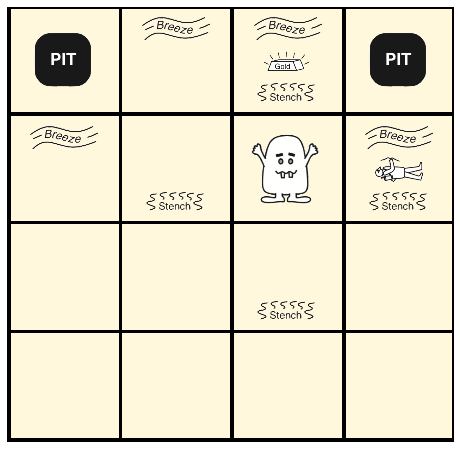

en posicion de disparo
ubiación final del self: (3, 2)
dir final:  {'norte'}
prob_wumpus: (2, 2)
pos_agente: (3, 2), dir: norte - pos_wumpus: (2, 2)
dir actual: norte
acciones apuntar:  ['voltearIzquierda']
oeste
dir final: oeste


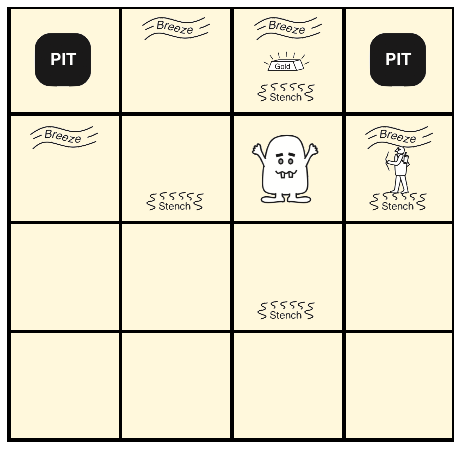

listo para disparar
¡El wumpus ha caido!
¡El wumpus ha sido impactado!


In [57]:
# codigo de ejecución 

W = Wumpus(wumpus=None, oro=(2,3), pozos=[(0,3), (3,3)])
agente = Agente_wkb()
formulas = agente.fluentes_mapa_mental_wkb()
formulas += agente.brisa_pozo_wkb()
formulas += agente.hedor_wumpus_wkb()
formulas += agente.casilla_segura_wkb()
formulas += agente.alerta_wumpus()
formulas += [f'en(0,0)_1', 'mirando_e_1', 'segura(0,0)']
agente.base = LPQuery(formulas)
agente.perceptos = W.para_sentidos()
c = agente.interp_percepto_wkb(mundo='wumpus')
agente.base.TELL(c)
print("¡Base de conocimiento creada!")

alertas = [] # lista que guarda las casillas en donde es probable que el wumpus esta

for i in range(40):
    print(agente.loc)
    a = agente.reaccionar_wkb()
    formula_accion = f'{a}_{agente.turno-1}'
    agente.base.TELL(formula_accion)
    W.transicion(a)
    if not W.juego_activo:
        clear_output(wait=True)
        W.pintar_todo()
        print(W.mensaje)
        break
    agente.estimar_estado_wkb(W)
    alertas += agente.lista_alertas()
    clear_output(wait=True)
    W.pintar_todo()
    plt.show()
    sleep(.25) 

#alertas = explorar_lab(alertas)
prob_wumpus = agente.identifica_wumpus(alertas)
disparo_seguro = agente.disparo_seguro(prob_wumpus) # encuentra lugares seguros de disparo
agente.casilla_apunta(disparo_seguro)
agente.apunta(prob_wumpus) # se dirige a la casilla de disparo

print("listo para disparar")
agente.turno += 1
a = 'disparar'
W.transicion(a)
formula_accion = f'{a}_{agente.turno-1}'
agente.base.TELL(formula_accion)
#agente.estimar_estado_wkb(W)

if not W.wumpus_vivo: 
    print("¡El wumpus ha sido impactado!")

else: 
    print("intento fallido. Wumpus vivo. :v")